In [141]:
import pandas as pd
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams


import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler



from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
# from keras.optimizers import RMSprop, adam

## Importing Data

In [2]:
day1_dataset_1min = pd.read_csv('Data Slices/day1_dataset_1min_10Aug2022.csv')
day1_dataset_10min = pd.read_csv('Data Slices/day1_dataset_10min_10Aug2022.csv')
day1_dataset_30min = pd.read_csv('Data Slices/day1_dataset_30min_10Aug2022.csv')
day1_dataset_60min = pd.read_csv('Data Slices/day1_dataset_60min_10Aug2022.csv')

In [3]:
def get_X_and_y(df, x_columns, y_columns):
    X = df[x_columns]
    y = df[y_columns]
    return X, y

In [4]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [5]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [6]:
def scale_dataset(sequences, columns = ['Price_USD', 'Price_Crypto', 'volume', 'densities', 'vertex_count', 
                              'edge_count','vertext_edge_ratio'], fitted_scaler = None):
    collection_blacklist_dict = {sequence[0]:sequence[2] for sequence in sequences}
    concat_df = pd.concat([sequence[1] for sequence in sequences])
    if fitted_scaler is None:
        fitted_scaler = StandardScaler()
        fitted_scaler.fit(concat_df[columns])
    concat_df[columns] = fitted_scaler.transform(concat_df[columns])
    return  [(collection, group[columns], collection_blacklist_dict[collection]) 
             for collection, group in concat_df.groupby("collection")] , fitted_scaler

In [7]:
def get_all_sequences(all_df):
    sequence_dict = {}
    for df in all_df: 
        df = df.drop(['Unnamed: 0'], axis=1)
        x_columns =  ['Datetime_updated_seconds','Price_USD','Price_Crypto','volume','densities',
                   'vertex_count','edge_count','collection']
        y_columns = ['blacklisted','collection']
        feature_columns=['Price_USD','Price_Crypto','volume',
                         'densities', 'vertex_count','edge_count', 'collection', 'vertext_edge_ratio']
        X, y= get_X_and_y(df, x_columns, y_columns)
        X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']
        sequence_dict = get_daily_sequences(X, y, feature_columns, sequence_dict)
    return sequence_dict

In [363]:
def retrieve_all_train_test_sequences(all_df):
    train_test_sequences = []
    all_sequence_dict = list(get_all_sequences(all_df).items())
    
    x = [sequence for sequence in all_sequence_dict]
    y = [sequence[1][1] for sequence in all_sequence_dict]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
         
    for train, test in  sss.split(x, y):
        X_train = [x[idx] for idx in train]
        X_test = [x[idx] for idx in test]
    return X_train, X_test

In [364]:
train_sequences, test_sequences = retrieve_all_train_test_sequences([day1_dataset_1min, day1_dataset_10min,
                                                                     day1_dataset_30min,
                                                                     day1_dataset_60min])

<ipython-input-7-f9d6ae458486>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']


In [366]:
def scale_train_test_sequences(train_sequences, test_sequences):
    scaled_train_dataset_dict = {}
    scaled_test_dataset_dict = {}
    scaled_train_dataset= []
    scaled_test_dataset= []
    length = len(train_sequences[0][1][0])
    for n in range(length):
        train_scaled, scaler = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                              train_sequences])
        test_scaled, _ = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                        test_sequences],
                      fitted_scaler= scaler)
        scaled_train_dataset.append(train_scaled)
        scaled_test_dataset.append(test_scaled)

    for scale_sequence in scaled_train_dataset:
        for collection in scale_sequence:
            if scaled_train_dataset_dict.get(collection[0]):
                scaled_train_dataset_dict[collection[0]][0].append(collection[1])
            else:
                scaled_train_dataset_dict[collection[0]] = ([collection[1]], collection[2])

    for scale_sequence in scaled_test_dataset:
        for collection in scale_sequence:
            if scaled_test_dataset_dict.get(collection[0]):
                scaled_test_dataset_dict[collection[0]][0].append(collection[1])
            else:
                scaled_test_dataset_dict[collection[0]] = ([collection[1]], collection[2])
                
    return list(scaled_train_dataset_dict.values()), list(scaled_test_dataset_dict.values())

In [368]:
train_values, test_values = scale_train_test_sequences(train_sequences,test_sequences)

In [369]:
test_values[1][0][3]

,Price_USD,Price_Crypto,volume,densities,vertex_count,edge_count,vertext_edge_ratio
48,2.795798,1.167894,-0.024188,1.067039,-0.117342,-0.110717,0.993254
49,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
50,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
51,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
52,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
53,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
54,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
55,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
56,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254
57,2.795798,1.167894,-0.066417,1.067039,-0.117342,-0.110717,0.993254


In [370]:
train_values[356][0][3]

,Price_USD,Price_Crypto,volume,densities,vertex_count,edge_count,vertext_edge_ratio
10872,-0.263761,-0.281734,-0.024188,1.067039,-0.117342,-0.110717,0.993254
10873,-0.263761,-0.281734,-0.066417,1.067039,-0.117342,-0.110717,0.993254
10874,-0.263761,-0.281734,-0.066417,1.067039,-0.117342,-0.110717,0.993254
10875,-0.263725,-0.281705,-0.024188,0.139612,-0.108276,-0.104048,-0.308734
10876,-0.263690,-0.281676,-0.024188,0.139612,-0.108276,-0.104048,-0.308734
10877,-0.263690,-0.281676,-0.066417,0.139612,-0.108276,-0.104048,-0.308734
10878,-0.263707,-0.281691,0.018042,-0.602330,-0.090144,-0.090710,-0.959727
10879,-0.263707,-0.281691,-0.066417,-0.602330,-0.090144,-0.090710,-0.959727
10880,-0.263707,-0.281691,-0.066417,-0.602330,-0.090144,-0.090710,-0.959727
10881,-0.263707,-0.281691,-0.066417,-0.602330,-0.090144,-0.090710,-0.959727


## Model

In [ ]:
train_values = list(scaled_train_dataset_dict.values())

In [ ]:
test_values = list(scaled_test_dataset_dict.values())

In [24]:
len(train_values[0][0])

4

In [25]:
for n in range(len(train_values[0][0])):
    print(n)

0
1
2
3


In [307]:
model_shapes = [train_values[0][0][n].shape for n in range(len(train_values[0][0]))]

In [308]:
model_shapes

[(1440, 7), (144, 7), (48, 7), (24, 7)]

In [371]:
filters = [200,200,200,200]
k_sizes = [100,10,6,4]

In [384]:
def get_base_model(shape, k_size = K_SIZE1, num_filters = NUM_FILTERS1):
    print("base model shape", shape)
    input_seq = Input(shape=shape)
    nb_filters = num_filters
    convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #todo: fix maxpooling
#     processed = MaxPooling1D(pool_size=2, strides=1, padding='same')(convolved)
    compressed = Dense(100, activation="relu")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    model.summary()
    return model

In [385]:
def main_model(shapes, filters, k_sizes):
    inputs = [Input(shape=shape, name=f'input{n}')for n, shape in enumerate(shapes)]
    sub_models = [ get_base_model(shape, k_size = k_sizes[n], num_filters=filters[n]) 
                  for n, shape in enumerate(shapes)]
    print(sub_models[0].output)
    embeddings = [ model(inputs[n]) for n, model in enumerate(sub_models)]
    merged = Concatenate()(embeddings)
    #todo: tweak dense be modifiable 
    layer1 = Dense(100, activation='relu', name ='hidden_layer1')(merged)
    layer2 = Dense(50, activation='relu', name ='hidden_layer2')(layer1)
    layer3 = Dense(25, activation='relu', name ='hidden_layer3')(layer2)
    out = Dense(1, activation='sigmoid')(layer3)
    model = Model(inputs=inputs, outputs=out)
    return model

In [386]:
def run_model(train, validation, model_shapes, filters, k_sizes):
    es = keras.callbacks.EarlyStopping(min_delta=0.00001, patience=20)
    model = main_model(model_shapes, filters, k_sizes)
    model.compile(loss='binary_crossentropy', # categorical_crossentropy
                          optimizer='adam', #sgd, nadam, adam, rmsprop
                          metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                                   tf.keras.metrics.AUC(curve='PR')])
    model.summary()
    model_hist = model.fit(train,
                               validation_data=validation,
                               batch_size=200, epochs=2000, 
                           callbacks=[es]
                          )
    return model_hist, model

In [387]:
def get_formatted_inputs(values):
    x_train_arr = []
    length = len(values)
    for n in range(len(values[0][0])):
        x_train = [sequence[0][n] for sequence in values]
        shape = x_train[0].shape
        x_train =  np.stack(x_train)
        x_train = x_train.reshape(length, shape[0], shape[1])
        x_train_arr.append(x_train)
    return x_train_arr, [sequence[1] for sequence in values]

In [388]:
def retrieve_tensor_datasets(train, test):
    formatted_train = ({f'input{n}': data for n, data in enumerate(train[0]) }, train[1])
    formatted_test = ({f'input{n}': data for n, data in enumerate(test[0]) }, test[1])
    train_dataset = tf.data.Dataset.from_tensor_slices(formatted_train).batch(200)
    test_dataset = tf.data.Dataset.from_tensor_slices(formatted_test).batch(200)
    return train_dataset, test_dataset

In [389]:
dataset, validation = retrieve_tensor_datasets(get_formatted_inputs(train_values),
                                               get_formatted_inputs(test_values) )

In [390]:
model_hist, model = run_model(dataset, validation, model_shapes, filters, k_sizes)

base model shape (1440, 7)
Model: "model_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 1440, 7)]         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 1440, 200)         140200    
_________________________________________________________________
global_max_pooling1d_96 (Glo (None, 200)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_116 (Dropout)        (None, 100)               0         
Total params: 160,300
Trainable params: 160,300
Non-trainable params: 0
_________________________________________________________________
base model shape (144, 7)
Model: "model_135"
_____________________________________________

Epoch 3/2000
4/4 [==============================] - 6s 2s/step - loss: 0.5781 - binary_accuracy: 0.7236 - precision_17: 0.0000e+00 - recall_17: 0.0000e+00 - auc_17: 0.3404 - val_loss: 0.5603 - val_binary_accuracy: 0.7236 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_auc_17: 0.3524
Epoch 4/2000
4/4 [==============================] - 6s 2s/step - loss: 0.5617 - binary_accuracy: 0.7236 - precision_17: 0.0000e+00 - recall_17: 0.0000e+00 - auc_17: 0.3528 - val_loss: 0.5595 - val_binary_accuracy: 0.7236 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_auc_17: 0.3608
Epoch 5/2000
4/4 [==============================] - 6s 2s/step - loss: 0.5549 - binary_accuracy: 0.7236 - precision_17: 0.0000e+00 - recall_17: 0.0000e+00 - auc_17: 0.3830 - val_loss: 0.5538 - val_binary_accuracy: 0.7236 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_auc_17: 0.3548
Epoch 6/2000
4/4 [==============================] - 5s 1s/step - loss: 0.5484 - binary_accuracy: 

4/4 [==============================] - 6s 2s/step - loss: 0.4520 - binary_accuracy: 0.7877 - precision_17: 0.7339 - recall_17: 0.3636 - auc_17: 0.6288 - val_loss: 0.5493 - val_binary_accuracy: 0.7236 - val_precision_17: 0.5000 - val_recall_17: 0.2364 - val_auc_17: 0.4760
Epoch 32/2000
4/4 [==============================] - 6s 2s/step - loss: 0.3967 - binary_accuracy: 0.8128 - precision_17: 0.8447 - recall_17: 0.3955 - auc_17: 0.7288 - val_loss: 0.5499 - val_binary_accuracy: 0.7186 - val_precision_17: 0.4762 - val_recall_17: 0.1818 - val_auc_17: 0.4734
Epoch 33/2000
4/4 [==============================] - 5s 1s/step - loss: 0.4237 - binary_accuracy: 0.8003 - precision_17: 0.7194 - recall_17: 0.4545 - auc_17: 0.6836 - val_loss: 0.5833 - val_binary_accuracy: 0.7236 - val_precision_17: 0.5000 - val_recall_17: 0.1455 - val_auc_17: 0.4787
Epoch 34/2000
4/4 [==============================] - 5s 1s/step - loss: 0.4085 - binary_accuracy: 0.8040 - precision_17: 0.8636 - recall_17: 0.3455 - auc_17

In [ ]:
prediction[prediction <=0.5] = 0
prediction[prediction >0.5] = 1

In [ ]:
[pred[0] for pred in prediction.tolist()]

In [249]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_binary_accuracy'] + history.history['binary_accuracy']),
                        max(history.history['val_binary_accuracy'] + history.history['binary_accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['binary_accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['binary_accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_binary_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [391]:
def plot_training_curves_auc(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_auc_17'] + history.history['auc_17']),
                        max(history.history['val_auc_17'] + history.history['auc_17']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['auc_17']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['auc_17'], label = 'auc')
    ax[1].plot(index, history.history['val_auc_17'], label = 'val_auc')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('AUC')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [ ]:
plot_training_curves(history=model_hist)

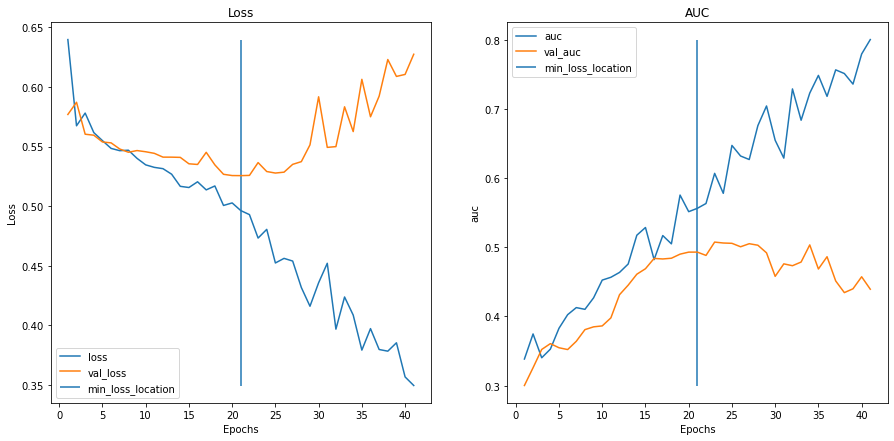

In [392]:
plot_training_curves_auc(history=model_hist)